# 深度卷积对抗生成网络


## 概述

### GAN（生成对抗网络）

GAN可以使深度学习模型获取训练数据的分布情况，因此我们可以以相同的分布生成新数据。最初，GAN由Ian Goodfellow 于2014年发明，并在论文[生成对抗网络](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中首次进行了描述。GAN由两个不同的模型组成：*生成器*和*判别器*。生成器的任务是生成看起来像训练图像的“假”图像。判别器需要判断从生成器输出的图片是真实的训练图像还是伪图像。在训练过程中，生成器会不断尝试通过生成更好的伪造品来超越判别器，而判别器在这过程中也会逐步提升判别能力。这种博弈的平衡点是，当生成器生成的伪造品看起来像训练数据时，判别器拥有50%的真假判断置信度。

在教程开始前，首先定义一些在整个过程中需要用到的符号：

- $x$：代表图像的数据；
- $D(x)$：判别器网络，给出图像判定为真图的概率，其中$x$来自于训练数据而非生成器；
由于我们在判别过程中需要处理图像，因此要为$D(x)$提供CHW格式且大小为`3x64x64`的图像。当$x$来自训练数据时，$D(x)$数值应该为高，而当$x$来自生成器时，$D(x)$数值应该为低。 因此$D(x)$也可以被认为是传统的二分类器；

接下来我们来定义生成器的表示方法：

- $z$：标准正态分布中采样的潜在空间向量；
- $G(z)$：表示将隐向量$z$映射到数据空间的生成器函数；

函数$G(z)$的目标是将一个随机高斯噪声$z$通过一个生成网络得到一个和真实数据分布$pdata(x)$差不多的生成数据分布，其中$θ$是网络参数，我们希望找到$θ$使得$pG(x;θ)$和$pdata(x)$尽可能的接近。

- $D(G(z))$是生成器$G$生成假样本被判定为真实图像的概率；

如[Goodfellow 的论文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中所述，`D`和`G`在进行一场博弈，`D`想要最大程度的正确分类真样本与假样本，也就是参数$log D(x)$；而`G`试图欺骗`D`来最小化假样本被识别到的概率，也就是参数$log(1−D(G(z)))$。GAN的损失函数为

![](images/tex22-1.gif)

从理论上讲，此博弈游戏的平衡点是$pG(x;θ) = pdata(x)$，此时判别器会随机猜测输入是真样本还是假样本。然而，GAN的收敛可行性仍在研究当中，在实际场景中模型并不会被训练到这一步。

### DCGAN（深度卷积对抗生成网络）

DCGAN是上述GAN的直接扩展。不同之处在于，DCGAN会分别在判别器和生成器中使用卷积和卷积转置层。它最早由Radford等人在论文[使用深度卷积生成对抗网络的无监督表示学习](https://arxiv.org/pdf/1511.06434.pdf)中进行描述。判别器由分层的卷积层、BatchNorm层和LeakyReLU激活层组成。输入是3x64x64的图像，输出是该图像为真图片的概率。生成器则是由转置卷积层、BatchNorm层和ReLU激活层组成。输入是标准正态分布提取出的潜在向量$z$，输出是3x64x64的RGB图像。在下面的教程中，提供了有关如何设置优化器、如何计算损失函数以及如何初始化模型权重的说明。

本教程将使用真实名人的照片来训练一个生成对抗网络（GAN），接着产生虚假名人图片。

为了节省运行时间，建议用户使用GPU/Ascend来运行本实验。

## 准备环节

### 导入模块

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision
from mindspore.common.initializer import Initializer
from mindspore import nn, ops, Tensor, context
from mindspore.common import dtype as mstype

### 配置环境

本教程我们在Ascend环境下，使用图模式运行实验。

In [2]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

### 准备数据

在本教程中，我们将使用[Celeb-A Faces 数据集](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)，所需下载数据集的压缩包名为`img_align_celeba.zip`。因数据集较大，本教程为了节省下载和训练时间，所以采用了部分的数据集。为了完整流畅地运行程序，需要在当前路径下创建一个`data`目录，并在`data`目录下创建一个名为`celeba`的目录，并将压缩文件解压缩到该目录中。最后，将此教程的`dataroot`输入设置为刚创建的`celeba`目录。

在Jupyter Notebook中执行如下命令下载数据集。

In [3]:
!mkdir -p ./data/celeba 
!wget -NP ./data/celeba https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/middleclass/img_align_celeba.rar
!unrar x ./data/celeba/img_align_celeba.rar

目录结构如下

```py
./data/celeba
    -> img_align_celeba
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...

```


## 数据处理

让我们为执行过程定义一些输入：

- `dataroot`：数据集文件夹根目录；
- `workers`：加载数据的线程数；
- `batch_size`：训练中使用的批量大小，DCGAN论文使用的批量大小为128；
- `image_size`：训练图像的大小，此实现默认为`64x64`，如果需要其他尺寸，则必须同时更改`D`和`G`的结构；
- `nc`：输入图像中的彩色通道数，因为此次是彩色图像所以设为3；
- `nz`：潜在向量的长度；
- `ngf`：设置通过生成器的特征图的深度；
- `ndf`：设置通过判别器传播的特征图的深度；
- `num_epochs`：要运行的训练周期数，训练更长的时间可能会导致更好的结果，但也会花费更长的时间；
- `lr`：训练的学习率，如DCGAN论文中所述，此数字应为0.0001；
- `beta1`：Adam优化器的`beta1`超参数。如DCGAN论文所述，该数字应为0.5；


In [4]:
# 数据集根目录
dataroot = "./data/celeba"

# 载入数据线程数
workers = 4

# 批量大小
batch_size = 128

# 训练图像空间大小，所有图像都将调整为该大小
image_size = 64

# 图像彩色通道数，对于彩色图像为3
nc = 3

# latent vector的长度
nz = 100

# 特征图在生成器中的大小
ngf = 64

# 特征图在判别器中的大小
ndf = 64

# 训练周期数
num_epochs = 10

# 学习率
lr = 0.0001

# Beta1 超参数
beta1 = 0.5

现在进行数据处理，并展示一些数据：

In [5]:
def create_dataset_imagenet(dataset_path, num_parallel_workers=None):
    """
    创建训练和验证的数据集
    """
    
    data_set = ds.ImageFolderDataset(dataset_path, num_parallel_workers=num_parallel_workers, shuffle=True)

    # 定义映射操作
    transform_img = [
        vision.Decode(),
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW()
    ]

    data_set = data_set.map(input_columns="image", num_parallel_workers=num_parallel_workers, operations=transform_img,
                            output_columns="image")
    data_set = data_set.map(input_columns="image", num_parallel_workers=num_parallel_workers,
                          operations=lambda x: ((x - 255) / 255).astype("float32"))
    data_set = data_set.map(
        input_columns="image",
        operations=lambda x: (
            x,
            np.random.normal(size=(nz, 1, 1)).astype("float32")
        ),
        output_columns=["image", "latent_code"],
        column_order=["image", "latent_code"],
        num_parallel_workers=num_parallel_workers
    )
    # 进行批量操作
    data_set = data_set.batch(batch_size)

    return data_set
# 生成实例
data = create_dataset_imagenet(dataroot, num_parallel_workers=workers)
size = data.get_dataset_size()

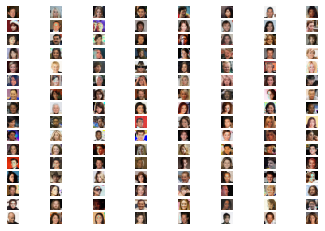

In [6]:
data_iter = next(data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs))
images = data_iter['image']
count=1
# 测试生成器生成数据，大小为（16，8）
for i in images:
    plt.subplot(16,8,count)
    plt.imshow(i.transpose(1,2,0))
    plt.axis("off")
    plt.xticks([])
    count += 1
plt.show()

## 实现

当处理完数据后，就可以来进行网络的搭建了。网络搭建将以权重初始化策略为起点，逐一详细讨论生成器、判别器、损失函数和训练循环的实现方法。

### 权重初始化

教程遵循DCGAN论文中的内容，所有模型权重均应从`mean`为0，`sigma`为0.02的正态分布中随机初始化：

In [7]:
class Normal(Initializer):
    def __init__(self, mean=0.0, sigma=0.02):
        super(Normal, self).__init__()
        self.sigma = sigma
        self.mean = mean

    def _assignment(arr, num):
        if arr.shape == ():
            arr = arr.reshape((1))
            arr[:] = num
            arr = arr.reshape(())
        else:
            if isinstance(num, np.ndarray):
                arr[:] = num[:]
            else:
                arr[:] = num
        return arr
    
    def _initialize(self, arr):
        np.random.seed(999)
        arr_normal = np.random.normal(self.mean, self.sigma, arr.shape)
        _assignment(arr, arr_normal)

### 生成器

生成器`G`的功能是将潜在空间向量`z`映射到数据空间。由于数据是图像，这一过程也会创建与真图大小相同的 RGB 图像。在实践场景中，该功能是通过一系列二维卷积转置层来完成的，每个层都与2d BatchNorm层和ReLu激活层配对，输出数据会经过tanh函数，返回`[-1,1]`的范围内。在卷积转置后进行批量处理有助于训练过程中的梯度传输，这也是DCGAN论文的关键贡献。

DCGAN论文生成图像如下所示。

![dcgan_generator](images/dcgan.png)

> 图片来源 https://arxiv.org/pdf/1511.06434.pdf

我们通过输入部分中设置的`nz`、`ngf`和`nc`来影响代码中的生成器结构。`nz`是`z`输入向量的长度，`ngf`与通过生成器传播的特征图的大小有关，`nc`是输出图像中的通道。

以下是生成器的代码实现：

In [8]:
def convt(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2dTranspose(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding,
                              weight_init=weight_init, has_bias=False, pad_mode=pad_mode)


def bm(num_features):
    gamma_init = Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)


class Generator(nn.Cell):
    """
    DCGAN网络生成器
    """

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell()
        self.generator.append(convt(nz, ngf * 8, 4, 1, 0))
        self.generator.append(bm(ngf * 8))
        self.generator.append(nn.ReLU())
        self.generator.append(convt(ngf * 8, ngf * 4, 4, 2, 1))
        self.generator.append(bm(ngf * 4))
        self.generator.append(nn.ReLU())
        self.generator.append(convt(ngf * 4, ngf * 2, 4, 2, 1))
        self.generator.append(bm(ngf * 2))
        self.generator.append(nn.ReLU())
        self.generator.append(convt(ngf * 2, ngf, 4, 2, 1))
        self.generator.append(bm(ngf))
        self.generator.append(nn.ReLU())
        self.generator.append(convt(ngf, nc, 4, 2, 1))
        self.generator.append(nn.Tanh())

    def construct(self, x):
        return self.generator(x)


现在，我们可以实例化生成器。 并通过打印出的模型以查看生成器对象的结构。

In [9]:
netG = Generator()
print(netG)

Generator<
  (generator): SequentialCell<
    (0): Conv2dTranspose<input_channels=100, output_channels=512, kernel_size=(4, 4),stride=(1, 1),  pad_mode=pad, padding=0, dilation=(1, 1), group=1, has_bias=False,weight_init=<__main__.Normal object at 0x7fb021c21a90>, bias_init=zeros>
    (1): BatchNorm2d<num_features=512, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=1.gamma, shape=(512,), dtype=Float32, requires_grad=True), beta=Parameter (name=1.beta, shape=(512,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=1.moving_mean, shape=(512,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=1.moving_variance, shape=(512,), dtype=Float32, requires_grad=False)>
    (2): ReLU<>
    (3): Conv2dTranspose<input_channels=512, output_channels=256, kernel_size=(4, 4),stride=(2, 2),  pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False,weight_init=<__main__.Normal object at 0x7fb021c21710>, bias_init=zeros>
    (4): BatchNorm2d<num_f

### 判别器

如前所述，判别器`D`是一个二分类网络模型，输出判定该图像为真图的概率。通过一系列的`Conv2d`、`BatchNorm2d`和`LeakyReLU`层对其进行处理，最后通过`Sigmoid`激活函数得到最终概率。

DCGAN论文提到，使用卷积而不是通过池化来进行下采样是一个好习惯，因为它可以让网络学习自己的池化特征。所以如果需要更好解决此问题，可以用更多层进行迭代卷积扩展此架构，`BatchNorm`和`LeakyReLU`促进梯度的传输，这对于`G`和`D`的学习过程是至关重要的。

判别器的代码实现如下：

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight_init, has_bias=False, pad_mode=pad_mode)


def bm(num_features):
    gamma_init = Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)


class Discriminator(nn.Cell):
    """
    DCGAN网络判别器
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell()
        self.discriminator.append(conv(nc, ndf, 4, 2, 1))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf, ndf * 2, 4, 2, 1))
        self.discriminator.append(bm(ndf * 2))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 2, ndf * 4, 4, 2, 1))
        self.discriminator.append(bm(ndf * 4))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 4, ndf * 8, 4, 2, 1))
        self.discriminator.append(bm(ndf * 8))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 8, 1, 4, 1))
        self.discriminator.append(nn.Sigmoid())

    def construct(self, x):
        return self.discriminator(x)

现在我们可以跟生成器一样创建判别器的实例，并打印出判别器模型的结构了。

In [11]:
netD = Discriminator()
print(netD)

Discriminator<
  (discriminator): SequentialCell<
    (0): Conv2d<input_channels=3, output_channels=64, kernel_size=(4, 4),stride=(2, 2),  pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=Falseweight_init=<__main__.Normal object at 0x7fb021c2fb10>, bias_init=zeros, format=NCHW>
    (1): LeakyReLU<>
    (2): Conv2d<input_channels=64, output_channels=128, kernel_size=(4, 4),stride=(2, 2),  pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=Falseweight_init=<__main__.Normal object at 0x7fb021c2f410>, bias_init=zeros, format=NCHW>
    (3): BatchNorm2d<num_features=128, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=3.gamma, shape=(128,), dtype=Float32, requires_grad=True), beta=Parameter (name=3.beta, shape=(128,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=3.moving_mean, shape=(128,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=3.moving_variance, shape=(128,), dtype=Float32, requires_grad=False)>
    (4): Le

### WithLossCell

因为GAN结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。这里通过`WithLossCell`来计算损失值。

In [12]:
class WithLossCellG(nn.Cell):
    """生成器损失计算"""
    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellG, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, latent_code):
        """构建生成器损失计算结构"""
        ones = ops.Ones()
        fake_data = self.netG(latent_code)
        out = self.netD(fake_data)
        label = ones(out.shape, mstype.float32)
        loss = self.loss_fn(out, label)
        return loss

class WithLossCellD(nn.Cell):
    """判别器损失计算"""
    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellD, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, real_data, latent_code):
        """构建判别器损失计算结构"""
        ones = ops.Ones()
        zeros = ops.Zeros()

        out1 = self.netD(real_data)
        label1 = ones(out1.shape, mstype.float32)
        loss1 = self.loss_fn(out1, label1)

        fake_data = self.netG(latent_code)
        fake_data = F.stop_gradient(fake_data)
        out2 = self.netD(fake_data)
        label2 = zeros(out2.shape, mstype.float32)
        loss2 = self.loss_fn(out2, label2)
        return loss1 + loss2

### 损失函数和优化器

当定义了`D`和`G`后，接下来将使用MindSpore中定义的二进制交叉熵损失函数[BCELoss](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/nn/mindspore.nn.BCELoss.html)
，为`D`和`G`加上损失函数和优化器。

这里设置了两个单独的优化器，一个用于`D`，另一个用于`G`。这两个都是`lr = 0.0002`和`beta1 = 0.5`的Adam优化器。为此将真实标签定义为1，将虚假标签定义为0，该标签在分别计算`D`和`G`的损失时使用。

为了跟踪生成器的学习进度，生成遵循高斯分布的潜在向量 `fixed_noise`。在周期性的训练中，定期将`fixed_noise`输入到`G`中，可以看到形成于噪声中的图像。

In [13]:
# 初始化损失函数
criterion = nn.BCELoss(reduction='mean')
# 创建一批可视化的向量用来观察迭代器
np.random.seed(1)
fixed_noise = Tensor(np.random.randn(64, nz, 1, 1),dtype=mstype.float32)
# 为迭代器和判别器设置优化器
optimizerD = nn.Adam(netD.trainable_params(), learning_rate=lr, beta1=beta1)
optimizerG = nn.Adam(netG.trainable_params(), learning_rate=lr, beta1=beta1)


### 训练

训练分为两个主要部分：训练判别器和训练生成器。

- 训练判别器

  训练判别器的目的是最大程度地提高判别图像真伪的概率。按照Goodfellow的方法，是希望通过提高其随机梯度来更新判别器，所以我们要最大化$log D(x) + log(1 - D(G(z))$的值。


- 训练生成器

  如DCGAN论文所述，我们希望通过最小化$log(1 - D(G(z)))$来训练生成器，以产生更好的虚假图像。

在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计，将`fixed_noise`批量推送到生成器中，以直观地跟踪`G`的训练进度。

下面进行训练：

In [14]:
class DCGAN(nn.Cell):
    """定义DCGAN网络"""
    def __init__(self, myTrainOneStepCellForD, myTrainOneStepCellForG):
        super(DCGAN, self).__init__(auto_prefix=True)
        self.myTrainOneStepCellForD = myTrainOneStepCellForD
        self.myTrainOneStepCellForG = myTrainOneStepCellForG

    def construct(self, real_data, latent_code):
        """定义网络结构"""
        output_D = self.myTrainOneStepCellForD(real_data, latent_code).view(-1)
        netD_loss = output_D.mean()
        output_G = self.myTrainOneStepCellForG(latent_code).view(-1)
        netG_loss = output_G.mean()
        return netD_loss, netG_loss

In [15]:
# 定义生成器和判别器的损失
netD_with_criterion = WithLossCellD(netD, netG, criterion)
netG_with_criterion = WithLossCellG(netD, netG, criterion)

# 创建训练实例
myTrainOneStepCellForD = nn.TrainOneStepCell(netD_with_criterion, optimizerD)
myTrainOneStepCellForG = nn.TrainOneStepCell(netG_with_criterion, optimizerG)

# 实例化DCGAN网络
dcgan = DCGAN(myTrainOneStepCellForD, myTrainOneStepCellForG)
dcgan.set_train()

# 实例迭代器
data_loader = data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs)
G_losses = []
D_losses = []
iters = 0
image_list = []

# 开始训练循环
print("Starting Training Loop...")
for epoch in range(num_epochs):
    # 为每轮训练读入数据
    for i, d in enumerate(data_loader):
        real_data = Tensor(d['image'])
        latent_code = Tensor(d["latent_code"])
        netD_loss, netG_loss = dcgan(real_data, latent_code)
        if i % 50 == 0:
            # 输出训练记录
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'% (epoch+1, num_epochs, i, size, netD_loss.asnumpy(), netG_loss.asnumpy()))
        D_losses.append(netD_loss.asnumpy())
        G_losses.append(netG_loss.asnumpy())
        if (iters % 500) == 0 or ((epoch == num_epochs) and (i == size-1)):
            img = netG(fixed_noise)
            image_list.append(img)    
        iters += 1


Starting Training Loop...
[1/10][0/153]	Loss_D: 2.4155	Loss_G: 3.0528
[1/10][50/153]	Loss_D: 0.1173	Loss_G: 7.3825
[1/10][100/153]	Loss_D: 0.5753	Loss_G: 13.9285
[1/10][150/153]	Loss_D: 0.9081	Loss_G: 11.9169
[2/10][0/153]	Loss_D: 0.6015	Loss_G: 11.9894
[2/10][50/153]	Loss_D: 0.3696	Loss_G: 3.9093
[2/10][100/153]	Loss_D: 1.2483	Loss_G: 9.7618
[2/10][150/153]	Loss_D: 0.7020	Loss_G: 5.4714
[3/10][0/153]	Loss_D: 0.8303	Loss_G: 2.3730
[3/10][50/153]	Loss_D: 0.2925	Loss_G: 4.6378
[3/10][100/153]	Loss_D: 0.3595	Loss_G: 3.7335
[3/10][150/153]	Loss_D: 0.2308	Loss_G: 4.5632
[4/10][0/153]	Loss_D: 0.2883	Loss_G: 3.6152
[4/10][50/153]	Loss_D: 0.4645	Loss_G: 3.4381
[4/10][100/153]	Loss_D: 0.8277	Loss_G: 1.4492
[4/10][150/153]	Loss_D: 0.4396	Loss_G: 3.5887
[5/10][0/153]	Loss_D: 0.2426	Loss_G: 3.6511
[5/10][50/153]	Loss_D: 0.3359	Loss_G: 4.1618
[5/10][100/153]	Loss_D: 0.5763	Loss_G: 6.5028
[5/10][150/153]	Loss_D: 0.2435	Loss_G: 4.7946
[6/10][0/153]	Loss_D: 0.1913	Loss_G: 4.8037
[6/10][50/153]	Loss_D:


## 结果

运行下面代码，描绘`D`和`G`损失与训练迭代的关系图：

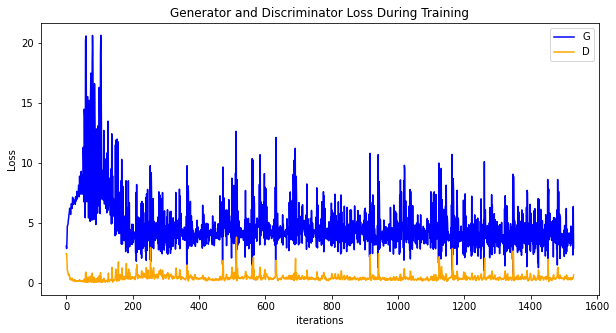

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G",color='blue')
plt.plot(D_losses,label="D",color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

通过之前保存的`fixed_noise`，来展示`G`的整个训练过程：

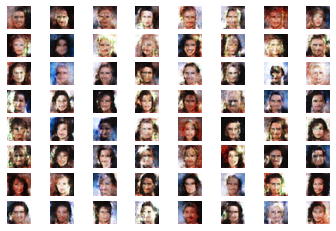

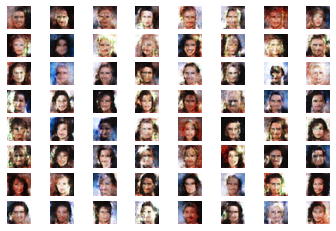

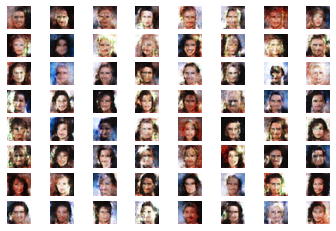

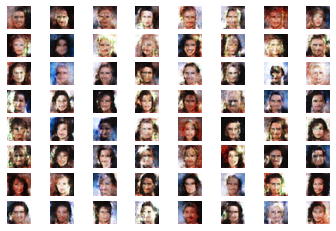

In [17]:
count = 1
for i in image_list:
    i[i< 0] = 0
    for j in i:
        plt.subplot(8,8,count)
        plt.imshow(j.asnumpy().transpose(1,2,0))
        plt.xticks([])
        count += 1
        plt.axis("off")
    count = 1
    plt.show()

由上图可见训练过的网络成功生成了虚假名人图片。